In [1]:
import numpy as np
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import PIL
import tensorflow as tf
import random
import re
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
#disable_eager_execution()
enable_eager_execution()

In [4]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_datasets as tfds

In [5]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot

In [6]:
def preprocess_image(features):
    """Preprocesses the given image.

      Args:
        image: `Tensor` representing an image of arbitrary size.

      Returns:
        A preprocessed image `Tensor` of range [0, 1].
  """
    image = features["image"]
    image = tf.image.resize(image,[224,224])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)
    
    features["image"] = image
    return features["image"], features["label"]

# Load Data and model

In [13]:
BATCH_SIZE = 50
tfds_dataset2, tfds_info  = tfds.load(name='imagenet2012_subset', split='validation[-60%:]', with_info=True,
                                     data_dir='/local/rcs/wei/image_net/') # use the last 20% of images among 50000 validation images for testing
#tf.compat.v1.data.make_one_shot_iterator(tfds_dataset1).get_next()

In [14]:
val_ds = tfds_dataset2.map(preprocess_image).batch(BATCH_SIZE).prefetch(1)

In [15]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
model_ = ResNet50(input_shape=input_shape)

In [16]:
q_model = tfmot.quantization.keras.quantize_model(model_)

In [17]:
model = ResNet50(input_tensor = q_model.input)

In [18]:
model.load_weights("./fp_model_40_resnet50.h5")
q_model.load_weights("./q_model_40_resnet50.h5")

# Fetch sample images

In [20]:
n_samples_per_class = 200

In [31]:
agreement = set()
q_correct_orig_wrong = set()
q_wrong_orig_correct = set()
for n, features in enumerate(val_ds):

    logits = model.predict(features[0])
    q_logits = q_model.predict(features[0])
    p = set([(i + n*BATCH_SIZE) for i, j in enumerate(zip(list(tf.argmax(logits, axis=-1).numpy()),list(features[1].numpy()))) if all(j[0]==k for k in j[1:])])
    q_p = set([(i + n*BATCH_SIZE) for i, j in enumerate(zip(list(tf.argmax(q_logits, axis=-1).numpy()),list(features[1].numpy()))) if all(j[0]==k for k in j[1:])])
    if len(agreement) <n_samples_per_class:
        agreement.update(p.intersection(q_p))
    if len(q_correct_orig_wrong) <n_samples_per_class:
        q_correct_orig_wrong.update(q_p.difference(p))
    if len(q_wrong_orig_correct) <n_samples_per_class:
        q_wrong_orig_correct.update(p.difference(q_p))
    if (n + 1) % BATCH_SIZE == 0:
        print("Finished %d examples" % ((n + 1) * 50))
        print(len(agreement) + len(q_correct_orig_wrong) + len(q_wrong_orig_correct))
    if len(agreement) + len(q_correct_orig_wrong) + len(q_wrong_orig_correct) >= n_samples_per_class*3:
        break
    
agreement = agreement
q_correct_orig_wrong = q_correct_orig_wrong
q_wrong_orig_correct = q_wrong_orig_correct

Finished 2500 examples
435
Finished 5000 examples
572


In [32]:
len(q_correct_orig_wrong)

180

In [33]:
qc_y = np.zeros((len(q_correct_orig_wrong),), dtype=int)

In [34]:
len(agreement)

216

In [35]:
bc_y = np.ones((len(agreement),), dtype=int)

In [36]:
len(q_wrong_orig_correct)

205

In [37]:
fpc_y = np.ones((len(q_wrong_orig_correct),), dtype=int) + np.ones((len(q_wrong_orig_correct),), dtype=int)

In [78]:
fp_layer_outputs = [layer.output for layer in model.layers if layer.name == 'avg_pool' ][0] 
fp_visual_model = tf.keras.models.Model(inputs = model.input, outputs = fp_layer_outputs)
q_layer_outputs = [layer.output for layer in q_model.layers if layer.name == 'quant_avg_pool' ][0]   
q_visual_model = tf.keras.models.Model(inputs = q_model.input, outputs = q_layer_outputs)

In [81]:
bc_images_fp = np.empty((0,2048))
bc_images_q = np.empty((0,2048))
bc_labels = np.empty((0))
for n, features in enumerate(val_ds):
    index = np.array(list(set([*range(0 + n*50 ,50 + n*50)]) & agreement)) - n*50
    if index.size != 0:
        fp = fp_visual_model.predict(features[0].numpy()[index])
        q = q_visual_model.predict(features[0].numpy()[index])
        bc_images_fp = np.concatenate((bc_images_fp, fp), axis=0)
        bc_images_q = np.concatenate((bc_images_q, fp), axis=0)
        bc_labels = np.concatenate((bc_labels, features[1].numpy()[index]), axis=0)

In [82]:
bc_images_fp.shape

(216, 2048)

In [83]:
qc_images_fp = np.empty((0,2048))
qc_images_q = np.empty((0,2048))
qc_labels = np.empty((0))
for n, features in enumerate(val_ds):
    index = np.array(list(set([*range(0 + n*50 ,50 + n*50)]) & q_correct_orig_wrong)) - n*50
    if index.size != 0:
        fp = fp_visual_model.predict(features[0].numpy()[index])
        q = q_visual_model.predict(features[0].numpy()[index])
        qc_images_fp = np.concatenate((qc_images_fp, fp), axis=0)
        qc_images_q = np.concatenate((qc_images_q, fp), axis=0)
        qc_labels = np.concatenate((qc_labels, features[1].numpy()[index]), axis=0)

In [84]:
qc_images_fp.shape

(180, 2048)

In [85]:
fpc_images_fp = np.empty((0,2048))
fpc_images_q = np.empty((0,2048))
fpc_labels = np.empty((0))
for n, features in enumerate(val_ds):
    index = np.array(list(set([*range(0 + n*50 ,50 + n*50)]) & q_wrong_orig_correct)) - n*50
    if index.size != 0:
        fp = fp_visual_model.predict(features[0].numpy()[index])
        q = q_visual_model.predict(features[0].numpy()[index])
        fpc_images_fp = np.concatenate((fpc_images_fp, fp), axis=0)
        fpc_images_q = np.concatenate((fpc_images_q, fp), axis=0)
        fpc_labels = np.concatenate((fpc_labels, features[1].numpy()[index]), axis=0)

In [86]:
fpc_images_fp.shape

(205, 2048)

In [87]:
images_fp = np.concatenate((np.concatenate((fpc_images_fp,qc_images_fp), axis=0), bc_images_fp),axis=0)

In [88]:
images_q = np.concatenate((np.concatenate((fpc_images_q,qc_images_q), axis=0), bc_images_q),axis=0)

In [89]:
labels = np.concatenate((np.concatenate((fpc_y,qc_y), axis=0), bc_y),axis=0)

In [93]:
images_fp.shape

(601, 2048)

# PCA

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [119]:
#x = images_fp.flatten().reshape(images_fp.shape[0], images_fp.shape[1]*images_fp.shape[2]*images_fp.shape[3])

In [150]:
x = images_q

In [151]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(x)
print(standardized_data.shape)

(601, 2048)


In [152]:
# initializing the pca
from sklearn import decomposition
pca = decomposition.PCA()


# configuring the parameteres
# the number of components = 2
pca.n_components = 2
pca_data = pca.fit_transform(standardized_data)

# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)

shape of pca_reduced.shape =  (601, 2)


In [153]:
import seaborn as sn
import pandas as pd

In [154]:
# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, labels)).T

/home/wei.hao/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


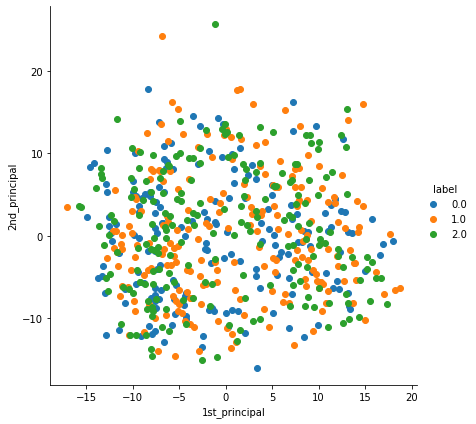

In [149]:
# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

/home/wei.hao/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


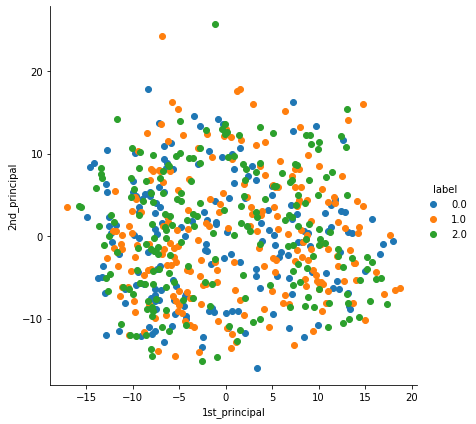

In [155]:
# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sn.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

# t-SNE using Scikit-Learn

/home/wei.hao/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


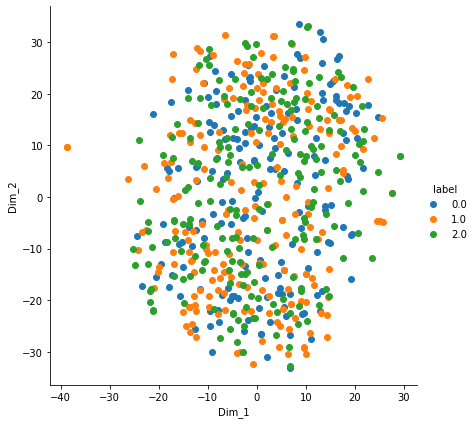

In [156]:
#https://distill.pub/2016/misread-tsne/

from sklearn.manifold import TSNE


model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

/home/wei.hao/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


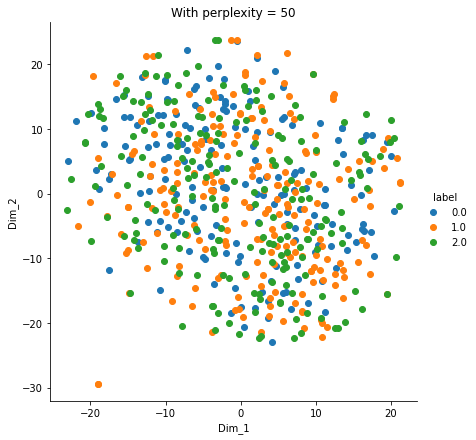

In [157]:
model = TSNE(n_components=2, random_state=0, perplexity=50)
tsne_data = model.fit_transform(standardized_data) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

/home/wei.hao/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


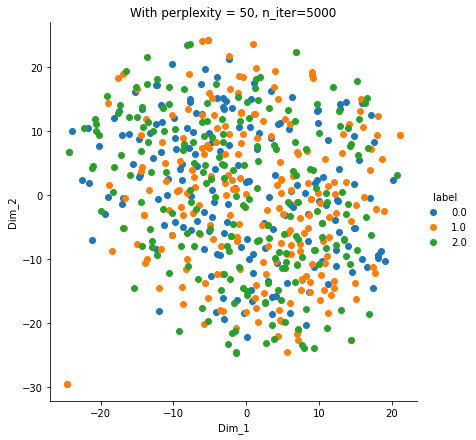

In [158]:
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)
tsne_data = model.fit_transform(standardized_data) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, n_iter=5000')
plt.show()

/home/wei.hao/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


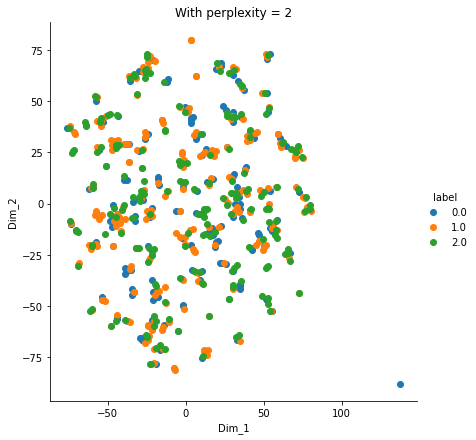

In [159]:
model = TSNE(n_components=2, random_state=0, perplexity=2)
tsne_data = model.fit_transform(standardized_data) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 2')
plt.show()